In [1]:

import numpy as np 
import pandas as pd 
import matplotlib as mpl
from matplotlib import pyplot as plt 
from abc import ABC, abstractmethod
import pickle



In [55]:
%pip install matplotlib


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [56]:
class Variable:
    def __init__(self, value) -> None:
        self.value = value
        self.grad = 0
        

In [ ]:

class Linear:
    def __init__(self,fan_in,fan_out,bias = True) -> None:
        self.weight = Variable(np.random.randn(fan_in, fan_out)/(fan_in)**0.5)  # could have taken fan_out as first dim -> must change the computations acc
        self.bias = Variable(np.random.randn(1,fan_out)) if bias else None
        self.aprev = None
    def __call__(self,x):
        # Farward pass with batch handling
        self.aprev = x
        self.out = x @ self.weight.value
        if self.bias is not None:
            self.out += self.bias.value
        return self.out
    def backward(self,dzl):
        # Backward pass with batch handling
        batch_size = dzl.shape[0]       #! input must have a batch size
        self.weight.grad = (self.aprev.T@dzl)/batch_size  # fan_in * batch_size @ batch_size * fan_out
        if self.bias is not None:
            self.bias.grad = np.sum(dzl,axis=0,keepdims=True) /batch_size  # batch_size*fan_out ----> 1*fanout
        daprev  =  dzl @ self.weight.value.T             #  batch_size * fan_out @ (fan_in * fan_out).T ---> batch_size * fan_in
        return daprev
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) 
          
    
    #----------------------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = np.tanh(x)
        return self.out
    def backward(self,dAl):
        self._der = dAl*(1 - self.out**2)
        return self._der
    def parameters(self):
        return []
# -----------------------------------------------------------------------------------------------

class Relu:
    def __call__(self, x):
        self.out = np.maximum(0, x)  # ReLU applies max(0, x) element-wise
        return self.out

    def backward(self, dAl):
        # Gradient is 1 where x > 0, else 0
        self._der = dAl * (self.out > 0).astype(float)
        return self._der
    def parameters(self):
        return []
# -----------------------------------------------------------------------------------------------
class LeakyRelu:
    def __call__(self, x,alpha = 0.01):
        self.alpha = alpha
        self.out = np.where(x > 0, x, self.alpha * x)  # Applies leaky behavior
        return self.out
    def backward(self, dAl):
        # Gradient is 1 where x > 0, else alpha
        self._der = dAl * np.where(self.out > 0, 1, self.alpha)
        return self._der
    def parameters(self):
        return []
# -----------------------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------------------
class Sigmoid:
    def __call__(self, x):
        self.out = 1 / (1 + np.exp(-x))  # Sigmoid function
        return self.out

    def backward(self, dAl):
        # Derivative of sigmoid is sigmoid(x) * (1 - sigmoid(x))
        self._der = dAl * self.out * (1 - self.out)
        return self._der

    def parameters(self):
        return []
# -----------------------------------------------------------------------------------------------
class Softmax:
    def __call__(self, x):
        x = x - np.max(x,axis=1,keepdims=True) # shape --> (batch_size,num_classes)
        logits = np.exp(x) 
        self.out = logits/np.sum(logits,axis=1,keepdims=True)
        return self.out
    def backward(self,dAl):
        return dAl  # Simplification due to integration with cross-entropy loss
        self._der = dAl*2*(1 - self.out)   # actually 2*(1 - self.out)*self.out but this will be cancelled out by the upcoming divider 
        return self._der
    def parameters(self):
        return []

#--------------------------------------------------------------------------------------------------------

class Sequential:
    def __init__(self, layers):
        self.layers = layers
        self.optimizer = None
        self.regulizer = None 
    def train(self):
        " switch all layers to training mode "
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = True
    def eval(self):
        "switch all layer to evaluation mode."
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = False
    def __call__(self, x,training = True):
        self.training = training
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def backprop(self,dypred):
        dAl = dypred
        for layer in reversed(self.layers[1:]):
            dAl = layer.backward(dAl)
        if self.regulizer is not None:
            self.regulizer.backward()
    """  gradient step will be handled by optimizer.step() method call"""
    # def update_params(self,lr = 0.1):
    #     for layer in self.layers:
    #         if hasattr(layer,'weight'):
    #             layer.weight -= lr*layer.dw  # adding the L-2 loss
    #         if hasattr(layer,'bias'):
    #             layer.bias -= lr*layer.db
    #         if isinstance(layer,BatchNorm):
    #             layer.gamma -= lr*layer.dgamma
    #             layer.beta -= lr*layer.dbeta
                 
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]
    def save(self,file_path):
        self.state_dict = []
        for layer in self.layers:
            layer_state = {}
            if isinstance(layer, (Linear, BatchNorm)):
                layer_state['Params'] = [param.value for param in layer.parameters()]
                if isinstance(layer,BatchNorm):
                    layer_state['running_mean'] = layer.running_mean
                    layer_state['running_var'] = layer.running_var
            else:
                layer_state['Params'] = None
            self.state_dict.append(layer_state)
        with open(file_path, 'wb') as f:
            pickle.dump(self.state_dict, f)
        print(f"Model saved to {file_path}")    
                       
    def load(self,file_path):
        with open(file_path, 'rb') as f:
            self.state_dict = pickle.load(f)
        for layer, layer_state in zip(self.layers,self.state_dict):
            if layer_state['Params'] is not None:
                for param,value in zip(layer.parameters(),layer_state['Params']):
                    if param.value.shape != value.shape:
                         print(f"Shape mismatch for layer: {layer}, expected {param.value.shape}, got {value.shape}")
                    param.value = value
                if isinstance(layer,BatchNorm):
                    layer.running_mean = layer_state.get('running_mean')
                    layer.running_var = layer_state.get('running_var')
        print(f"Model loaded from {file_path}")
        
#-------------------------------------------------------------------------------------------------------------

class BatchNorm:
    def __init__(self,dim,momentum = 0.1,eps=1e-15) -> None:
        self.gamma = Variable(np.ones((1,dim)))
        self.beta = Variable(np.zeros((1,dim)))
        # training with momentum updata
        self.running_mean = np.zeros(dim)
        self.running_var = np.ones(dim)  
        self.training = True 
        self.eps = eps
        self.momentum = momentum
        # intermediates for backward
        self.xvar = None
        self.xhat = None
        self.xnorm = None
    def __call__(self,x):
        if self.training:
            xmean = np.mean(x,axis=0,keepdims=True)
            # m = x.shape[0]
            xvar = np.var(x,axis=0,keepdims=True) # unbiased estimate for the variance
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            #use running statistics
            xmean = self.running_mean
            xvar = self.running_var
        
        self.xhat = x - xmean
        self.xvar = (xvar + self.eps)
        # normalizing input
        self.xnorm = self.xhat/(self.xvar**0.5) # xhat ~N(0,1)
        # scaling and shifting
        self.out = self.gamma.value*self.xnorm + self.beta.value
        return self.out
    def backward(self,dal):
        batch_size = dal.shape[0]
        
        #grad for gamma and beta 
        self.gamma.grad = np.sum(dal * self.xnorm, axis=0)
        self.beta.grad = np.sum(dal, axis=0)
        
        # grad wrt xnorm
        dxnorm = dal * self.gamma.value
        
        #gradient wrt variancec(xvar)
        dvar = np.sum(dxnorm * self.xhat * -0.5 * (self.xvar ** -1.5), axis=0)
        
        # gradient wrt mean (xmean)
        dmean = np.sum(dxnorm * -1 / np.sqrt(self.xvar), axis=0) + dvar * np.mean(-2 * self.xhat, axis=0)
        # gradient wrt input x/z
        # dL/dzl = dL/dz_nl*dz_nl/dzl + dL/dvar* dvar/dzl + dL/dmue*dmue/dzl
        dz =  dxnorm/np.sqrt(self.xvar) + (2/batch_size)* dvar * self.xhat + dmean/batch_size
        return dz
    def parameters(self):
        return [self.gamma,self.beta]

    """
    def backward01(self,dal):
        batch_size = dal.shape[0]
        self.dgama = np.sum(dal*self.xnorm,axis=0)
        self.dbeta = np.sum(dal,axis=0)
        # for dx we have take account of the mean and var we have calculated
        dz_ln = dal*self.gamma   # (batch_size,fan_out) *(1,fanout)  element-wise   broadcasting (1,fanout) -->(batch_size,fanout)
        # dvar = -0.5*np.ones(batch_size).T @ ( dz_ln * (self.xhat/self.xvar**(3/2)))     #  1.T @ ((batch_size,fanout) * (batch_size,fanout))  --> summing over the row (batch_size) resulting in (1,fanout)
        
        dvar = -0.5*np.sum( dz_ln * (self.xhat/self.xvar**(3/2)),axis=0)
        # for dmue there are two ways to achieve that  
        # dmue = (dL/dz_ln)*(dz_ln/dmue) + (dL/dvar)*(dvar/dmue) let say dmue1 and dmue2
        # dmue = -np.ones(batch_size).T @ (dz_ln * self.xvar**-0.5) # since dmue2 = 0 
        
        dmue = -np.sum(dz_ln / self.xvar**0.5,axis=0) + dvar*
        # from the DAg 
        # dL/dzl = dL/dz_nl*dz_nl/dzl + dL/dvar* dvar/dzl + dL/dmue*dmue/dzl
        
        # dz = (1/(batch_size* self.xvar**0.5))*(
        #     batch_size*dz_ln - np.ones((1,batch_size))@ dz_ln - self.xnorm*(np.ones((1,batch_size))@ (dz_ln * self.xnorm))
        # )
        dz = (1/(batch_size * self.xvar**0.5))*(
            batch_size*dz_ln - np.sum(dz_ln,axis=0) - self.xnorm*np.sum(dz_ln*self.xnorm,axis=0)
        )
        return dz
        
    """
#------------------------------------------------------------------------------------------------------------------------------------------------------------
class Dropout:
    def __init__(self, keep_prop = 0.9):
        self.keep_prop = keep_prop
        self.training = True
        self.mask = None
    def __call__(self,x):
        if self.training:
            self.mask = (np.random.rand(*x.shape) < self.keep_prop).astype(np.float32)
            return x*self.mask/self.keep_prop
        else:
            # we don't want to use Dropout while evaluation
            return x
    def backward(self,dAl):
        # gradient for the dropped neuron is zero while training 
        return dAl*self.mask if self.training else dAl
        
    def parameters(self):
        return []
        
            
        
        

Optimizer

In [58]:
class Optimizer(ABC):
    def __init__(self,parameters,lr = 0.01):
        self.parameters = parameters
        self.lr = lr
    @abstractmethod
    def step(self):
        pass

In [ ]:
class BGD(Optimizer):
    def __init__(self, parameters, lr=0.01):
        super().__init__(parameters, lr)
    def step(self):
        for params in self.parameters:
            params.value -= self.lr*params.grad
            
#----------------------------------------------------------------------------

class BGDwithMomentum(Optimizer):
    def __init__(self, parameters:Variable, lr=0.01,momentum = 0.9):     # averaging over 10 grads
        super().__init__(parameters, lr)
        self.momentum = momentum
        self.velocity = [np.zeros_like(params.value) for params in self.parameters]
        self.t = 0
    
    def step(self):
        self.t += 1
        for i,params in enumerate(self.parameters):
            """ bias correction in exponentialy weighted avg """
            self.velocity[i] = self.momentum*self.velocity[i] + (1 - self.momentum)*params.grad
            vel_unbiased = self.velocity[i]/(1 - self.momentum**self.t)
            params.value -= self.lr*vel_unbiased
            
#---------------------------------------------------------------------------------------------------------------------------------

class BGDwithMomentum(Optimizer):
    def __init__(self, parameters:Variable, lr=0.01,momentum = 0.9):     # averaging over 10 grads
        super().__init__(parameters, lr)
        self.momentum = momentum
        self.velocity = [np.zeros_like(params.value) for params in self.parameters]
        self.t = 0
    
    def step(self):
        self.t += 1
        for i,params in enumerate(self.parameters):
            """ bias correction in exponentialy weighted avg """
            self.velocity[i] = self.momentum*self.velocity[i] + (1 - self.momentum)*params.grad
            vel_unbiased = self.velocity[i]/(1 - self.momentum**self.t)
            params.value -= self.lr*vel_unbiased
#-------------------------------------------------------------------------------------------------------------------------------------


class Adam(Optimizer):
    def __init__(self, parameters, lr=0.01, beta1 = 0.9, beta2 = 0.999, eps = 1e-10):
        super().__init__(parameters, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps 
        self.velocity = [np.zeros_like(params.value) for params in self.parameters]
        self.square = [np.zeros_like(params.value) for params in self.parameters]
        self.t = 0
    def step(self):
        self.t += 1
        for i, params in enumerate(self.parameters):
            """ Includes bias correction""" 
            self.velocity[i] = (self.beta1*self.velocity[i] + (1 - self.beta1)*params.grad)
            self.square[i] = (self.beta2*self.square[i] + (1 - self.beta2)*params.grad**2)
            vel_unbiased = self.velocity[i]/(1 - self.beta1**self.t)
            sqr_unbiased = self.square[i]/(1 - self.beta2**self.t)
            params.value -= self.lr*vel_unbiased/np.sqrt(sqr_unbiased + self.eps)
            

            
           


            
            
        

grad-check for batchnorm

#duality

whenver there is a sum in forward prop --> that gives a hit that there will be some kind of replication or broadcasting in backward pass
and conversely when we have a replication or broadcasting in forward pass... that indicates the variable reuse -> so in backward pass that turns into a sum over the exact same dimension

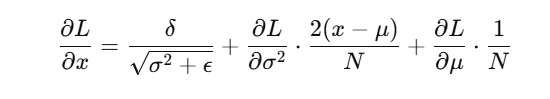

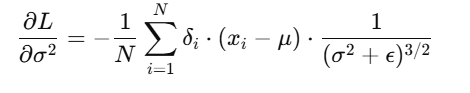

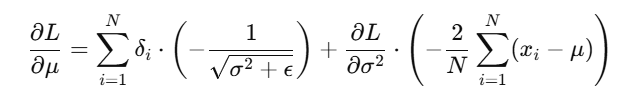

In [60]:
from typing import Any


class Loss(ABC):
    """Base class for the loss functions."""
    @abstractmethod
    def __call__(self, ypred, ytarget) -> Any:
        pass
    @abstractmethod
    def backward(self, ypred, ytarget):
        pass

In [61]:
class MSE_CostFunction(Loss):
    def __call__(self,ypred,ytarget):
        self.ypred = ypred
        self.ytarget = ytarget
        return np.mean((ytarget - ypred)**2)
    def backward(self):
        return (2*(self.ypred - self.ytarget))/self.ytarget.shape[0]
    
#-----------------------------------------------------------------------------------------------------------

class BinaryCrossEntropy:
    def __call__(self,ypred,ytarget, eps = 1e-15):
        self.ypred = np.clip(ypred,eps,1-eps) # numerical stability clips the values within the bound
        self.ytarget = ytarget
        return -np.mean(self.ytarget*np.log(self.ypred) + (1 - self.ytarget)*np.log(1 - self.ypred))    
    def backward(self):
        batch_size = self.ytarget.shape[0]
        return -((self.ytarget/self.ypred)  - (1 - self.ytarget)/(1 - self.ypred))/batch_size


#-------------------------------------------------------------------------------------------------------------

#  cover- ups the logic for softmax derivate for now 
class CrossEntropyLoss:
    def __call__(self,ypred,ytarget,eps = 1e-15):
        self.ypred = np.clip(ypred,eps,None)
        self.ytarget = ytarget
        return -np.mean(np.sum(self.ytarget*np.log(self.ypred),axis = 1))
    def backward(self):
        batch_size = self.ytarget.shape[0]
        return (self.ypred - self.ytarget )/batch_size

#------------------------------------------------------------------------------------------------------------

class L2regularizer(Loss):
    def __init__(self,model,L2_lambda = 0.0001):
        self.model = model
        self.L2lambda = L2_lambda
    
    def __call__(self):
        self.L2loss = 0
        for layer in self.model.layers:
            if hasattr(layer,'weight'):
                self.L2loss += (self.L2lambda/2)*np.sum(layer.weight.value**2)
        return self.L2loss
    def backward(self):
        for layer in self.model.layers:
            if isinstance(layer,Linear):
                layer.weight.grad += self.L2lambda*layer.weight.value
                
        
    

Testing with small data

In [ ]:
# Model definition
model = Sequential([
    Linear(784, 512,False),
    BatchNorm(512),
    Relu(),
    Dropout(keep_prop=0.85),

    Linear(512, 256,False),
    BatchNorm(256),
    Relu(),
    Dropout(keep_prop=0.7),
    
    Linear(256, 128,False),
    BatchNorm(128),
    Relu(),
    Dropout(keep_prop=0.85),
    
    Linear(128, 10,False),
    BatchNorm(10),
    Softmax() 
])

total_params = sum(np.prod(param.value.shape)  for param in model.parameters())
print("Total number of parameters:", total_params)


Total number of parameters: 568340


MOdel-For digit classification 


In [63]:
import struct

def load_images(filename):
    with open(filename, 'rb') as f:
        # Read the header
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        # Read image data
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows*cols)
        # standardizing the image
        images = images/255.0
        mean = np.mean(images,0)
        std = np.std(images,0)
        std[std == 0] = 1
        
        images = (images - mean) / std
    return images,mean,std

def load_labels(filename):
    num_classes = 10
    with open(filename, 'rb') as f:
        # Read the header
        magic, num = struct.unpack(">II", f.read(8))
        # Read label data
        labels = np.fromfile(f, dtype=np.uint8)
        labels = np.eye(num_classes)[labels]
    return labels

# Example usage
train_images,Mean,Std = load_images(r'C:\Users\kumar\d\deeplearning\andrej\CA_project\archive\train-images-idx3-ubyte\train-images-idx3-ubyte')
train_labels = load_labels(r'C:\Users\kumar\d\deeplearning\andrej\CA_project\archive\train-labels-idx1-ubyte\train-labels-idx1-ubyte')
print(Mean.shape,Std.shape)


(784,) (784,)


In [64]:
xs = train_images
ys = train_labels
xs.shape, ys.shape

((60000, 784), (60000, 10))

In [65]:
ratio = 0.8
n = xs.shape[0]
split_index = int(n*ratio)
xtrain,xval = xs[:split_index], xs[split_index:]
ytrain, yval = ys[:split_index], ys[split_index:]
xval.shape,yval.shape

((12000, 784), (12000, 10))

In [66]:
batch_size = 128
num_batches = xtrain.shape[0]//batch_size
num_batches
trainLossi = []
valLossi = []
model.optimizer = Adam(model.parameters())
# model.optimizer.t = 100

In [ ]:
from tqdm import tqdm
# model.load('model_checkpoint0.plk')

In [ ]:

num_samples = xtrain.shape[0]
model.regulizer = L2regularizer(model)
Criterion = CrossEntropyLoss()
flag = True
for i in tqdm(range(1, 150), desc="Epochs", unit="epoch"):
    model.train()
    epoch_loss = 0
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    xtrain_suffled = xtrain[indices]
    ytrain_suffled = ytrain[indices]
    for j in tqdm(range(0, num_samples, batch_size), desc="Batches", leave=False, unit="batch"):
        x_batch = xtrain_suffled[i:i+batch_size]
        y_batch = ytrain_suffled[i:i+batch_size]
        ypred = model(x_batch)
        # Loss calculation 
        epoch_loss +=Criterion(ypred,y_batch)
        epoch_loss += model.regulizer()
        # backpropogation
        dAl = Criterion.backward()
        model.backprop(dAl)
        model.optimizer.lr = 0.0001 if flag else 0.00001
        model.optimizer.step()
        
    epoch_loss /= (num_samples//batch_size)
    trainLossi.append(epoch_loss)
    if i % 10 == 0:
        print(f'Iteration {i}: Current Train loss = {epoch_loss:.4f}')
    if epoch_loss < 0.006 and flag:
        model.save('model_checkpoint0.plk')
        print("checkpoint saved!...")
        
        flag = False
        # print("Early stopping triggered, model saved.")
        

        

Epochs:   7%|▋         | 10/149 [02:13<30:50, 13.31s/epoch]

Iteration 10: Current Train loss = 0.1467


Epochs:  13%|█▎        | 20/149 [05:38<46:11, 21.48s/epoch]

Iteration 20: Current Train loss = 0.0633


Epochs:  20%|██        | 30/149 [09:23<45:25, 22.90s/epoch]

Iteration 30: Current Train loss = 0.0365


Epochs:  27%|██▋       | 40/149 [12:12<27:41, 15.24s/epoch]

Iteration 40: Current Train loss = 0.0184


Epochs:  34%|███▎      | 50/149 [14:44<25:32, 15.48s/epoch]

Iteration 50: Current Train loss = 0.0150


Epochs:  40%|████      | 60/149 [17:19<22:35, 15.23s/epoch]

Iteration 60: Current Train loss = 0.0136


Epochs:  47%|████▋     | 70/149 [20:15<26:37, 20.23s/epoch]

Iteration 70: Current Train loss = 0.0077


Epochs:  54%|█████▎    | 80/149 [23:53<24:50, 21.59s/epoch]

Iteration 80: Current Train loss = 0.0084


Epochs:  55%|█████▌    | 82/149 [24:36<24:07, 21.61s/epoch]

Model saved to model_checkpoint0.plk
checkpoint saved!...


Epochs:  60%|██████    | 90/149 [27:29<21:13, 21.58s/epoch]

Iteration 90: Current Train loss = 0.0075


Epochs:  67%|██████▋   | 100/149 [30:55<13:50, 16.95s/epoch]

Iteration 100: Current Train loss = 0.0074


Epochs:  74%|███████▍  | 110/149 [33:57<13:21, 20.54s/epoch]

Iteration 110: Current Train loss = 0.0045


Epochs:  81%|████████  | 120/149 [37:32<10:21, 21.43s/epoch]

Iteration 120: Current Train loss = 0.0081


Epochs:  87%|████████▋ | 130/149 [41:05<06:41, 21.14s/epoch]

Iteration 130: Current Train loss = 0.0055


Epochs:  94%|█████████▍| 140/149 [44:46<03:27, 23.02s/epoch]

Iteration 140: Current Train loss = 0.0077


Epochs: 100%|██████████| 149/149 [47:50<00:00, 19.26s/epoch]


In [16]:
# trainLossi = []
# valLossi = []
# num_samples = xtrain.shape[0]
# epoch_loss = 0
# model.optimizer = Adam(model.parameters())
# model.regulizer = L2regularizer(model)
# Criterion = CrossEntropyLoss()

# for i in range(1,201):
#     model.train()
#     indices = np.arange(num_samples)
#     np.random.shuffle(indices)
#     xtrain_suffled = xtrain[indices]
#     ytrain_suffled = ytrain[indices]
#     for j in range(0,num_samples,batch_size):
#         x_batch = xtrain_suffled[i:i+batch_size]
#         y_batch = ytrain_suffled[i:i+batch_size]
#         ypred = model(x_batch)
#         # print(ypred)
#         epoch_loss +=Criterion(ypred,y_batch)
#         epoch_loss += model.regulizer()
#         dAl = Criterion.backward()
#         model.backprop(dAl)
#         model.optimizer.lr = 0.0001
#         model.optimizer.step()
#     epoch_loss /= (num_samples//batch_size)
#     trainLossi.append(epoch_loss)
#     if i % 10 == 0:
#         # validation loss
#         # model.eval()
#         # hpred = model(xval)
#         # eval_loss = Criterion(yval,hpred)
#         # # append losses
#         # valLossi.append(eval_loss)
#         print(f'Iteration {i}: Current Train loss = {epoch_loss:.4f}')
#     if epoch_loss < 0.006:
#         model.save('model_checkpoint0.plk')
#         break
        

        

0.005935095804728306


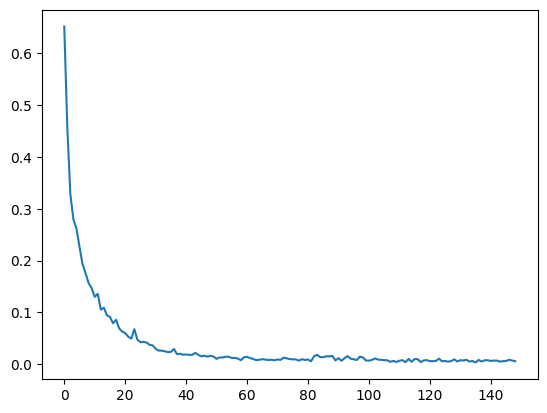

In [70]:
plt.plot(trainLossi)
print(trainLossi[-1])

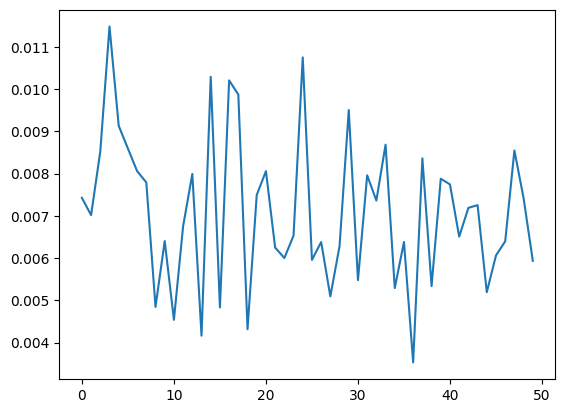

In [73]:
plt.plot(trainLossi[-50:])

In [74]:
import numpy as np
import struct

def load_images(filename):
    with open(filename, 'rb') as f:
        # Read the header
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        # Read image data
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows*cols)
        # standardizing the image
        images = images/255.0 
        images = (images - Mean) / Std
    return images

def load_labels(filename):
    num_classes = 10
    with open(filename, 'rb') as f:
        # Read the header
        magic, num = struct.unpack(">II", f.read(8))
        # Read label data
        labels = np.fromfile(f, dtype=np.uint8)
        labels = np.eye(num_classes)[labels]
    return labels

# Example usage
test_images = load_images(r'C:\Users\kumar\d\deeplearning\andrej\CA_project\archive\t10k-images-idx3-ubyte\t10k-images-idx3-ubyte')
test_labels = load_labels(r'C:\Users\kumar\d\deeplearning\andrej\CA_project\archive\t10k-labels-idx1-ubyte\t10k-labels-idx1-ubyte')


In [75]:
count = 0
for index in range(48000):
    model.eval()
    xs = xtrain[index].reshape(1,-1)
    ys = ytrain[index]
    ypred = model(xs)
    if(ypred.argmax() == ys.argmax()):
        count += 1
count

44411

In [76]:
count = 0
for index in range(12000):
    model.eval()
    xs = xval[index].reshape(1,-1)
    ys = yval[index]
    ypred = model(xs)
    if(ypred.argmax() == ys.argmax()):
        count += 1
count

11125

In [77]:
count = 0
for index in range(10000):
    xs = test_images[index].reshape(1,-1)
    ys = test_labels[index]
    ypred = model(xs)
    if(ypred.argmax() == test_labels[index].argmax()):
        count += 1
count

9251

9


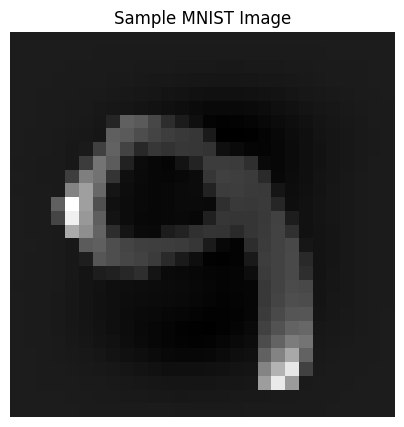

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize a single image

test_index = np.random.randint(0,10000)
xs = test_images[test_index].reshape(1,-1)
ypred = model(xs)
print(ypred.argmax())


def visualize_image(image, title="MNIST Image"):
    # Reshape the image to 28x28 for visualization
    image_reshaped = image.reshape(28, 28)
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(image_reshaped, cmap='gray', cbar= False, square=True)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the first image from the loaded dataset
visualize_image(test_images[test_index], title="Sample MNIST Image")



In [84]:
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

6


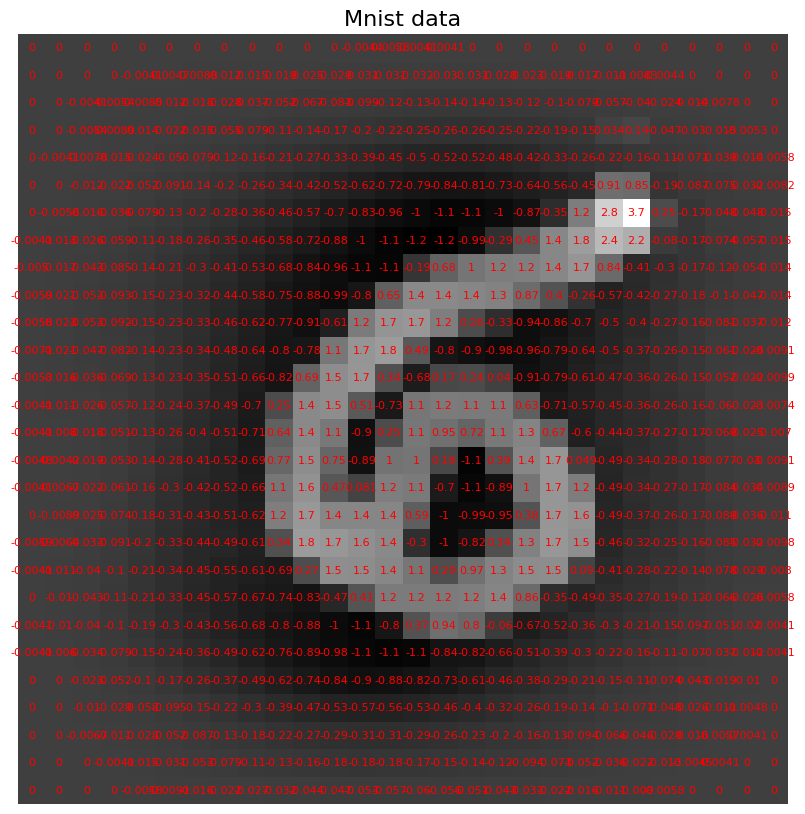

7


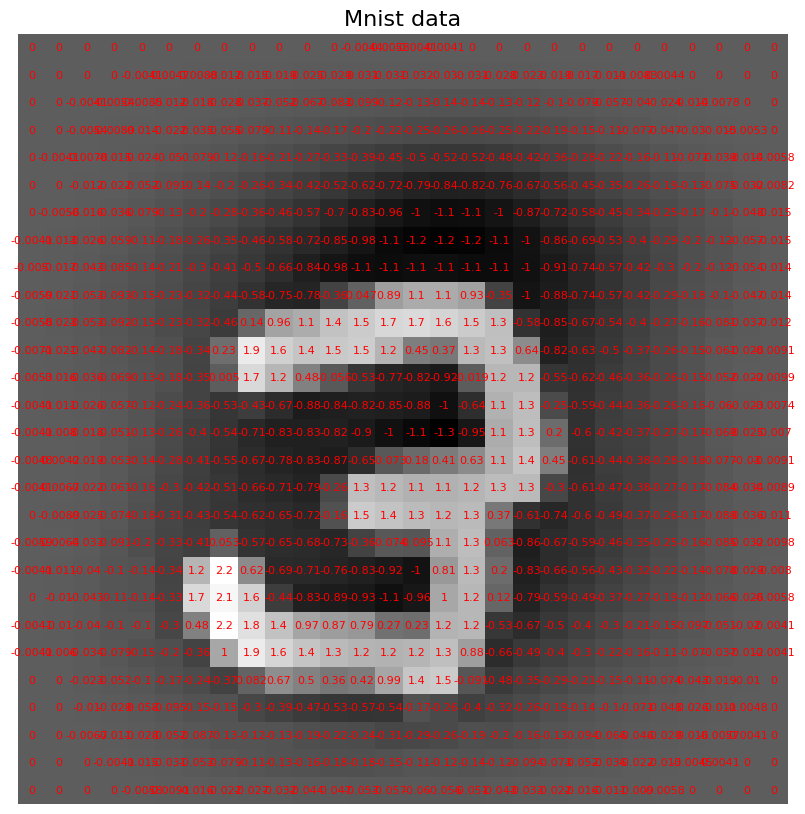

7


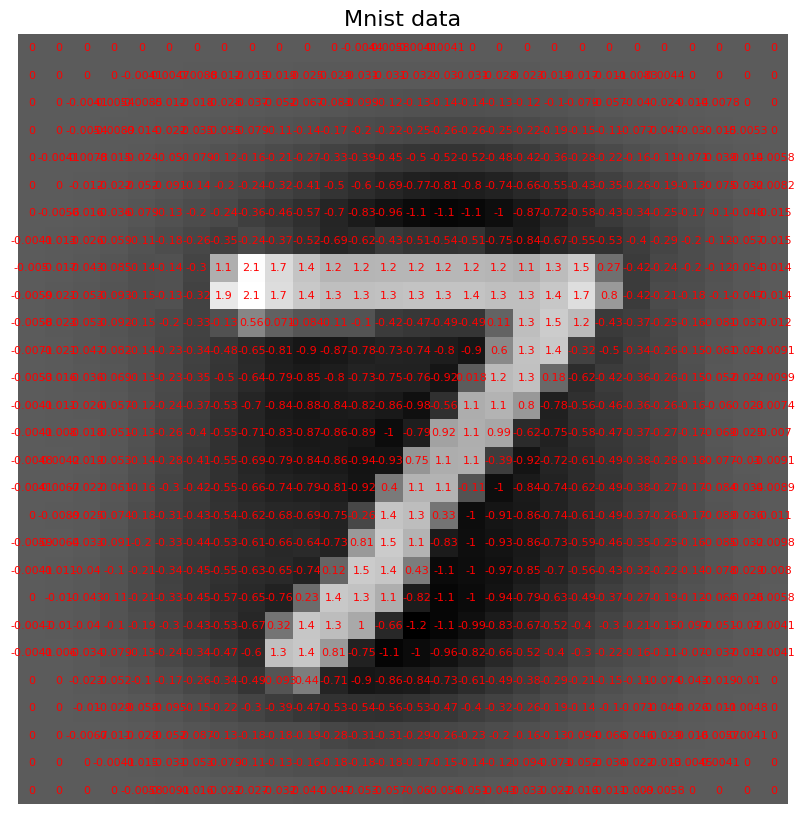

0


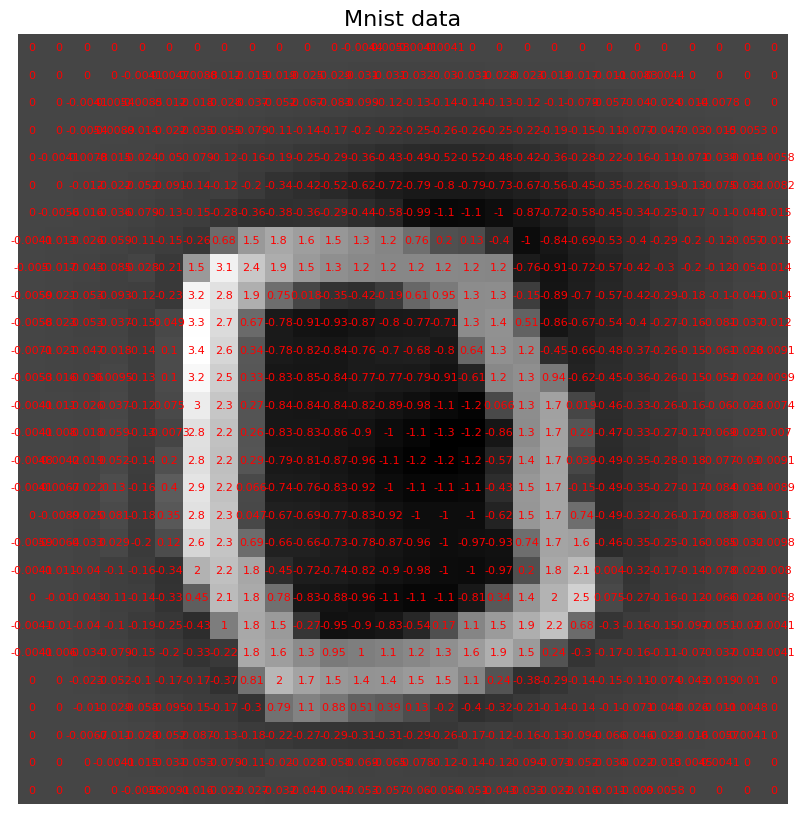

1


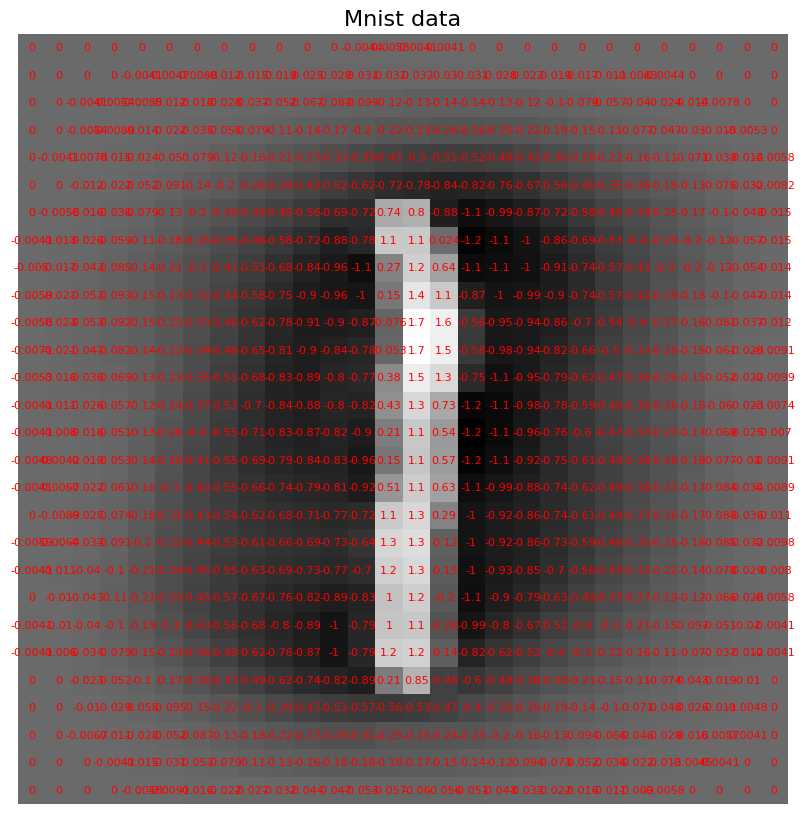

5


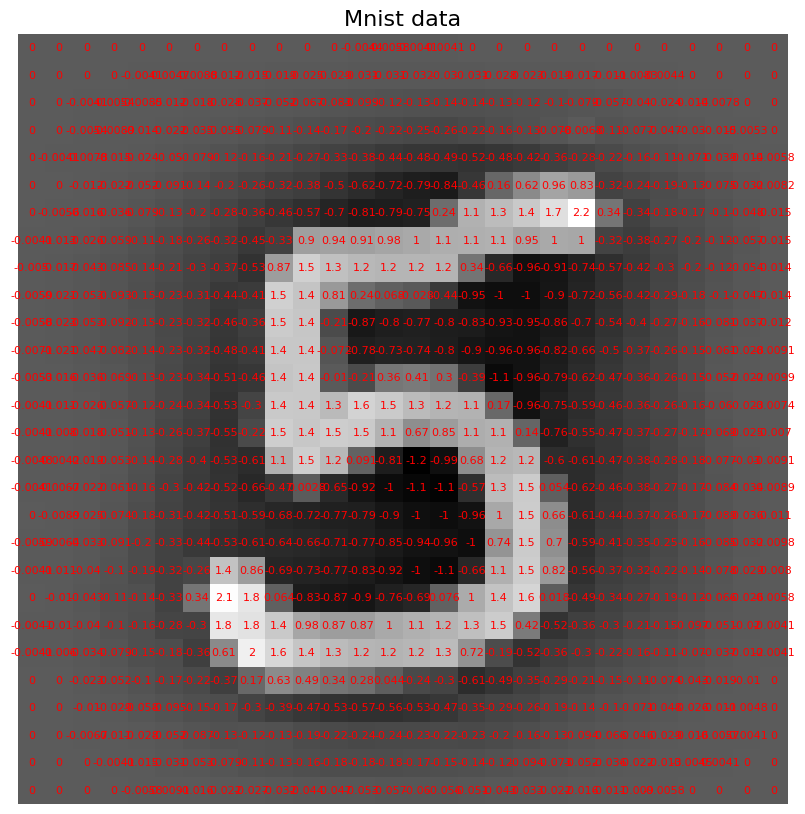

2


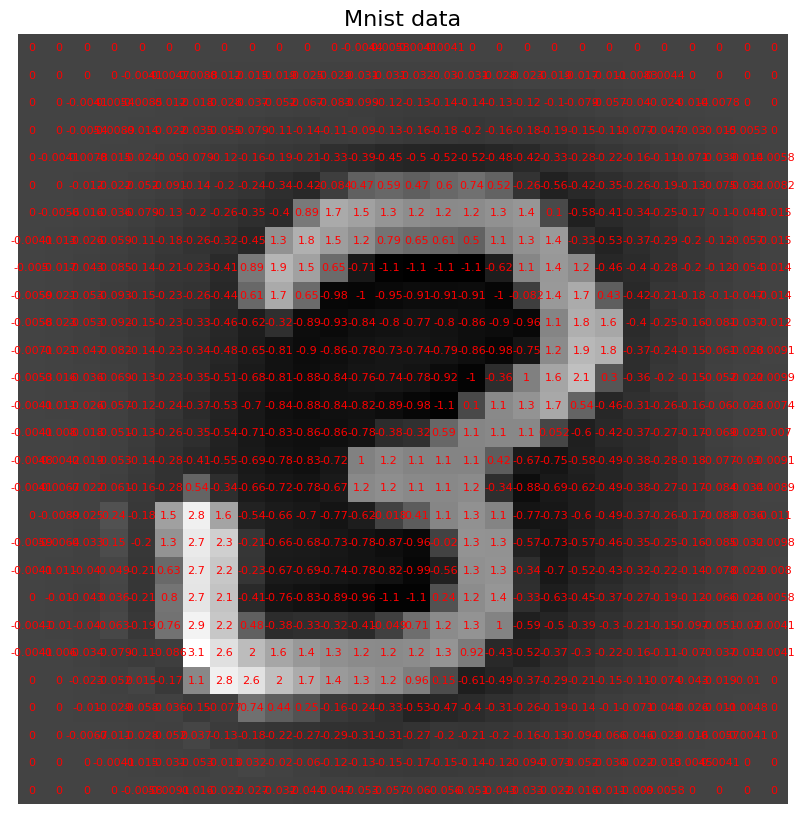

2


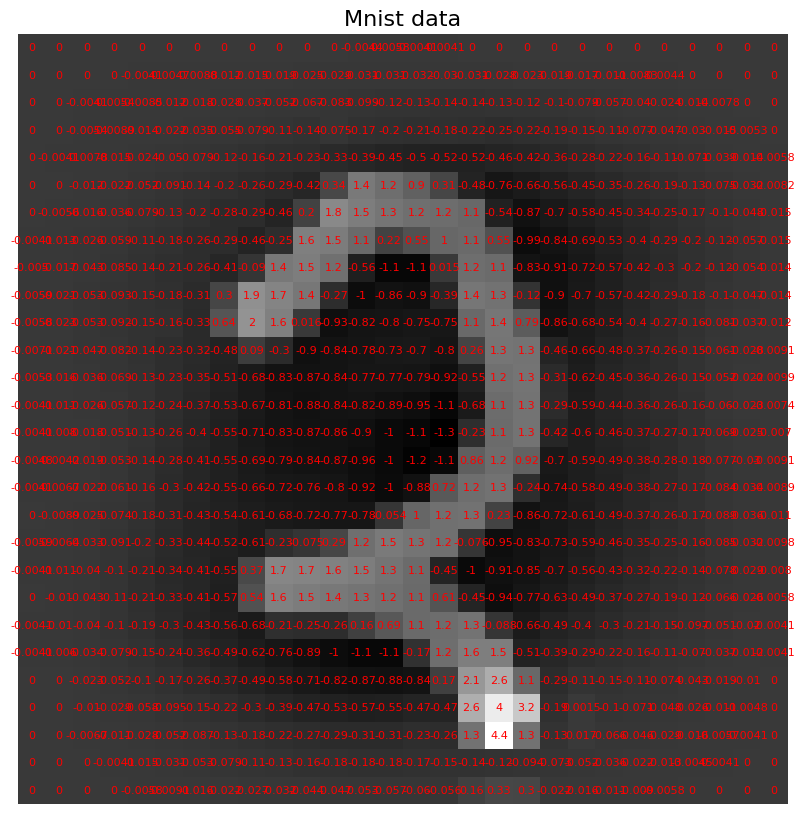

3


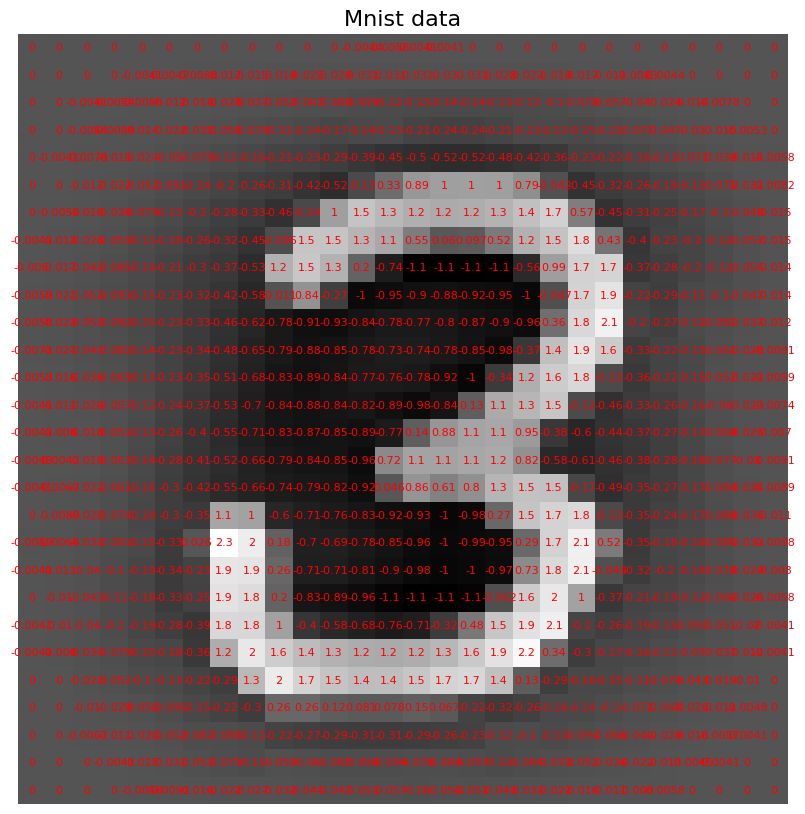

In [ ]:


# Initialize global variables for drawing
canvas_size = 200  # Size of the canvas
mnist_size = 28    # MNIST image size (28x28)
drawing = False    # Track if the user is drawing
line_width = 8     # Width of the brush

# Function to start drawing
def start_draw(event):
    global drawing
    drawing = True
    draw_point(event.x, event.y)

# Function to stop drawing
def stop_draw(event):
    global drawing
    drawing = False

# Function to draw on the canvas and in the PIL image
def draw_point(x, y):
    x1, y1 = x - line_width, y - line_width
    x2, y2 = x + line_width, y + line_width
    canvas.create_oval(x1, y1, x2, y2, fill="black", outline="black")
    draw.ellipse([x1, y1, x2, y2], fill="black", outline="black")

# Function to handle drawing when the mouse moves
def draw_motion(event):
    if drawing:
        draw_point(event.x, event.y)

# Function to clear the canvas
def clear_canvas():
    canvas.delete("all")
    draw.rectangle((0, 0, canvas_size, canvas_size), fill="white")

# Function to save and convert the drawing to MNIST format
def save_image():
    # Resize the image to 28x28 and invert colors to match MNIST format
    img_resized = img.resize((mnist_size, mnist_size), Image.LANCZOS)
    img_resized = ImageOps.invert(img_resized)

    # Convert to a numpy array and normalize
    mnist_image = np.array(img_resized).reshape(1,-1)
    mnist_image = mnist_image/255.0
    standardized_mnist_image = (mnist_image - Mean) / Std
    
    ypred = model(standardized_mnist_image)  
    print(ypred.argmax())
    title = "Sample MNIST Image"
    # Display the result using matplotlib
    image_reshaped = standardized_mnist_image.reshape(28,28)
    # plt.figure(figsize=(5, 5))
    # sns.heatmap(image_reshaped, cmap='gray', cbar=False, square=True)
    # plt.title(title)
    # plt.axis('off')
    # plt.show()
    plt.figure(figsize=(10, 10))  # Larger figure size for better readability
    ax = sns.heatmap(
        image_reshaped, 
        cmap='gray', 
        annot=True,  # Annotate with pixel values
           # Integer format for pixel intensity values
        cbar=False,  # Disable color bar for clarity
        square=True,
        annot_kws={"size": 8, "color": "red"}  # Custom font size and color for annotation
    )
    
    plt.title("Mnist data", fontsize=16)
    plt.axis('off')  # Hide axis for cleaner look
    plt.show()
    return standardized_mnist_image
    #print("MNIST-like Array:\n", mnist_array)



# Set up the main application window
root = tk.Tk()
root.title("Draw a Digit")

# Set up the canvas for drawing
canvas = tk.Canvas(root, width=canvas_size, height=canvas_size, bg="white")
canvas.pack()

# Create a PIL image and draw object to store the drawing
img = Image.new("L", (canvas_size, canvas_size), "white")
draw = ImageDraw.Draw(img)

# Bind mouse events to canvas for drawing
canvas.bind("<Button-1>", start_draw)
canvas.bind("<B1-Motion>", draw_motion)
canvas.bind("<ButtonRelease-1>", stop_draw)

# Add buttons for clearing and saving
btn_clear = tk.Button(root, text="Clear", command=clear_canvas)
btn_clear.pack(side="left", padx=10, pady=10)

btn_save = tk.Button(root, text="Save", command=save_image)
btn_save.pack(side="right", padx=10, pady=10)

# Run the application
root.mainloop()